# Mount drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Install dependencies

In [ ]:
!pip install lambeq[extras]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.1/152.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.2/148.2 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.3/364.3 kB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 77.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 88.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.9/306.9 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.1/246.1 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

# Import libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# QNLP
from lambeq.tokeniser import SpacyTokeniser
from lambeq import BobcatParser, spiders_reader, cups_reader, TreeReader, TreeReaderMode, stairs_reader
from lambeq import Rewriter, SimpleRewriteRule, remove_cups, AtomicType, IQPAnsatz
from discopy.tensor import Dim
from discopy.grammar.pregroup import Cap, Id, Diagram
N = AtomicType.NOUN
S = AtomicType.SENTENCE
P = AtomicType.PREPOSITIONAL_PHRASE
C = AtomicType.CONJUNCTION

# Training
from lambeq import NumpyModel, QuantumTrainer, SPSAOptimizer, Dataset, CrossEntropyLoss, PennyLaneModel, PytorchTrainer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

# SEED for reproducibility
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Load data

In [ ]:
QUANTUM_PATH = '/content/drive/MyDrive/Tesi/Master-Thesis/data/processed/quantum.csv'
CLASSICAL_PATH = '/content/drive/MyDrive/Tesi/Master-Thesis/data/processed/classical.csv'

df = pd.read_csv(CLASSICAL_PATH, index_col=False)

# Create string-diagrams
Uncomment rows for different readers

In [ ]:
def create_multi_diagrams(df, reader):
    diagrams, targets = [], []
    for _, row in enumerate(df.to_numpy()):
        sentence, target = row[0], row[1]
        try:
            diagrams.append(reader.sentence2diagram(sentence))
        except Exception as e:
            print(sentence)
            print(e)
            continue
        if target == "US":
            targets.append([1.0, 0.0, 0.0, 0.0])
        elif target == "SE":
            targets.append([0.0, 1.0, 0.0, 0.0])
        elif target == "O":
            targets.append([0.0, 0.0, 1.0, 0.0])
        elif target == "PE":
            targets.append([0.0, 0.0, 0.0, 1.0])
    return diagrams, targets

reader = spiders_reader
# reader = cups_reader
# reader = stairs_reader
# reader = TreeReader(ccg_parser=BobcatParser, mode = TreeReaderMode.RULE_TYPE)

# reader = BobcatParser(root_cats=['S'])

diagrams, targets = create_multi_diagrams(df, reader)

# Rewrite string-diagrams
This step is not performed for linear readers (spiders, cups, etc.).

In [ ]:
# def normalize_diagrams(diagrams):
#     normalized_diagrams = []
#     for i, diagram in enumerate(diagrams):
#         try:
#             normalized_diagrams.append(rewriter(diagram).normal_form())
#         except Exception as e:
#             print(e)
#             diagram.draw()
#             continue
#     return normalized_diagrams


# rewriter = Rewriter(['prepositional_phrase', 'determiner', 'connector', 'auxiliary', 'preadverb', 'curry', 'coordination'])
# diagrams = normalize_diagrams(diagrams)

# Parameterize diagrams
Uncomment rows for different anstaze

In [ ]:
def create_circuits(diagrams, ansatz):
    circuits = []
    for i, diagram in enumerate(diagrams):
        try:
            circuits.append(ansatz(remove_cups(diagram)))
        except Exception as e:
            print(e)
            diagram.draw(figsize=(8,5), fontsize=8)
            continue
    return circuits

ob_map = {
    AtomicType.SENTENCE: 2,
    AtomicType.NOUN: 1,
    AtomicType.PREPOSITIONAL_PHRASE: 1,
}

ansatz = IQPAnsatz(ob_map, n_layers=2, n_single_qubit_params=3)
circuits = create_circuits(diagrams, ansatz)

# # check for codomain errors
# for i,c in enumerate(se_circuits):
#     if str(c.cod) != 'qubit @ qubit':
#         print(se_df.loc[[i]])
#         se_normalized_diagrams[i].draw()

# Define evalutation metrics

In [ ]:
def accuracy(y_hat, y):
    y_true = torch.argmax(y, dim=1)
    y_pred = torch.argmax(y_hat, dim=1)
    return accuracy_score(y_true, y_pred)

def f1(y_hat, y):
    y_true = torch.argmax(y, dim=1)
    y_pred = torch.argmax(y_hat, dim=1)
    return f1_score(y_true, y_pred, average='weighted')

eval_metrics = {'acc': accuracy,
                'f1': f1}

# Define model

In [ ]:
class QuantumModel(PennyLaneModel):
    def __init__(self, **kwargs):
        PennyLaneModel.__init__(self, **kwargs)

    def forward(self, input):
        preds = self.get_diagram_output(input)
        return preds.reshape(-1, 4)

# Training

Processing Fold 1 ...


Epoch 25:   train/loss: 0.9903   valid/loss: 1.1424   train/acc: 0.9245   train/f1: 0.9235   valid/acc: 0.6389   valid/f1: 0.6441
Epoch 50:   train/loss: 0.8965   valid/loss: 1.1454   train/acc: 0.9465   train/f1: 0.9460   valid/acc: 0.5833   valid/f1: 0.5798
Epoch 75:   train/loss: 0.8875   valid/loss: 1.1473   train/acc: 0.9528   train/f1: 0.9528   valid/acc: 0.5833   valid/f1: 0.5798
Epoch 100:  train/loss: 0.8534   valid/loss: 1.1449   train/acc: 0.9623   train/f1: 0.9622   valid/acc: 0.5833   valid/f1: 0.5798

Training completed!


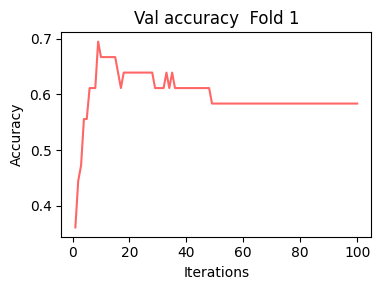

Processing Fold 2 ...


Epoch 25:   train/loss: 0.9415   valid/loss: 1.1411   train/acc: 0.9151   train/f1: 0.9140   valid/acc: 0.6667   valid/f1: 0.6693
Epoch 50:   train/loss: 0.9325   valid/loss: 1.1039   train/acc: 0.9308   train/f1: 0.9304   valid/acc: 0.6111   valid/f1: 0.5981
Epoch 75:   train/loss: 0.9072   valid/loss: 1.1090   train/acc: 0.9371   train/f1: 0.9370   valid/acc: 0.6111   valid/f1: 0.6102
Epoch 100:  train/loss: 0.8795   valid/loss: 1.1318   train/acc: 0.9497   train/f1: 0.9492   valid/acc: 0.5833   valid/f1: 0.5810

Training completed!


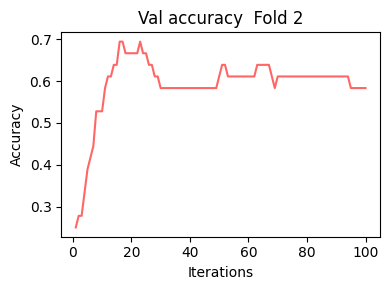

Processing Fold 3 ...


Epoch 25:   train/loss: 0.9615   valid/loss: 1.1388   train/acc: 0.9119   train/f1: 0.9109   valid/acc: 0.6389   valid/f1: 0.6403
Epoch 50:   train/loss: 0.8896   valid/loss: 1.1514   train/acc: 0.9245   train/f1: 0.9245   valid/acc: 0.6389   valid/f1: 0.6237
Epoch 75:   train/loss: 0.8902   valid/loss: 1.1516   train/acc: 0.9403   train/f1: 0.9402   valid/acc: 0.6389   valid/f1: 0.6342
Epoch 100:  train/loss: 0.8641   valid/loss: 1.1310   train/acc: 0.9434   train/f1: 0.9426   valid/acc: 0.6944   valid/f1: 0.6888

Training completed!


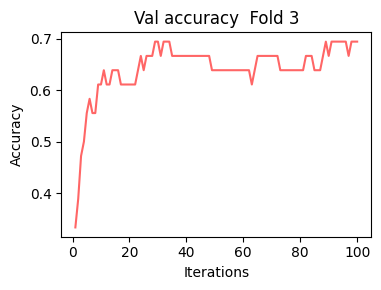

Processing Fold 4 ...


Epoch 25:   train/loss: 0.9630   valid/loss: 1.0914   train/acc: 0.8994   train/f1: 0.8988   valid/acc: 0.7222   valid/f1: 0.7226
Epoch 50:   train/loss: 0.9153   valid/loss: 1.0718   train/acc: 0.9214   train/f1: 0.9197   valid/acc: 0.7222   valid/f1: 0.7247
Epoch 75:   train/loss: 0.8797   valid/loss: 1.0926   train/acc: 0.9371   train/f1: 0.9368   valid/acc: 0.7222   valid/f1: 0.7288
Epoch 100:  train/loss: 0.8755   valid/loss: 1.1056   train/acc: 0.9465   train/f1: 0.9462   valid/acc: 0.6944   valid/f1: 0.6983

Training completed!


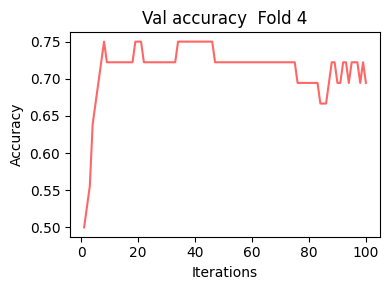

Processing Fold 5 ...


Epoch 25:   train/loss: 0.9573   valid/loss: 1.1313   train/acc: 0.9122   train/f1: 0.9117   valid/acc: 0.7143   valid/f1: 0.7205
Epoch 50:   train/loss: 0.8986   valid/loss: 1.1263   train/acc: 0.9467   train/f1: 0.9468   valid/acc: 0.6286   valid/f1: 0.6340
Epoch 75:   train/loss: 0.8877   valid/loss: 1.1260   train/acc: 0.9592   train/f1: 0.9592   valid/acc: 0.6000   valid/f1: 0.6071
Epoch 100:  train/loss: 0.8823   valid/loss: 1.1100   train/acc: 0.9624   train/f1: 0.9623   valid/acc: 0.6857   valid/f1: 0.6875

Training completed!


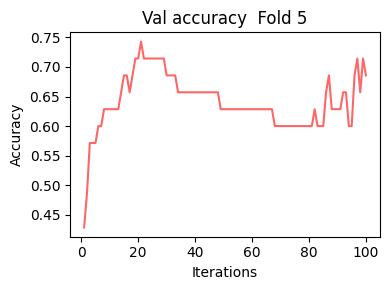

Processing Fold 6 ...


Epoch 25:   train/loss: 0.9109   valid/loss: 1.2352   train/acc: 0.9028   train/f1: 0.9027   valid/acc: 0.5714   valid/f1: 0.5662
Epoch 50:   train/loss: 0.8769   valid/loss: 1.1988   train/acc: 0.9342   train/f1: 0.9339   valid/acc: 0.6000   valid/f1: 0.5826
Epoch 75:   train/loss: 0.9067   valid/loss: 1.2031   train/acc: 0.9498   train/f1: 0.9497   valid/acc: 0.5143   valid/f1: 0.5063
Epoch 100:  train/loss: 0.8839   valid/loss: 1.2061   train/acc: 0.9436   train/f1: 0.9432   valid/acc: 0.5143   valid/f1: 0.4952

Training completed!


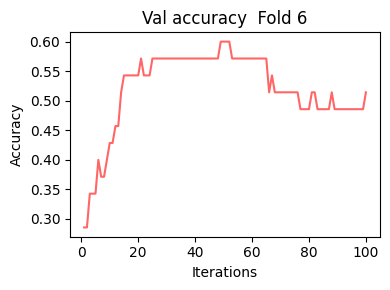

Processing Fold 7 ...


Epoch 25:   train/loss: 0.9941   valid/loss: 1.0955   train/acc: 0.9216   train/f1: 0.9211   valid/acc: 0.6286   valid/f1: 0.6237
Epoch 50:   train/loss: 0.8796   valid/loss: 1.0738   train/acc: 0.9279   train/f1: 0.9275   valid/acc: 0.7429   valid/f1: 0.7512
Epoch 75:   train/loss: 0.9060   valid/loss: 1.0739   train/acc: 0.9373   train/f1: 0.9372   valid/acc: 0.7429   valid/f1: 0.7483
Epoch 100:  train/loss: 0.8767   valid/loss: 1.0868   train/acc: 0.9436   train/f1: 0.9428   valid/acc: 0.6857   valid/f1: 0.6922

Training completed!


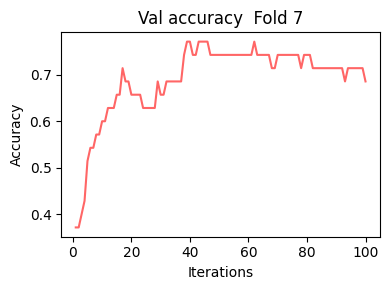

Processing Fold 8 ...


Epoch 25:   train/loss: 0.9820   valid/loss: 1.1324   train/acc: 0.9122   train/f1: 0.9121   valid/acc: 0.7143   valid/f1: 0.7184
Epoch 50:   train/loss: 0.9047   valid/loss: 1.1030   train/acc: 0.9404   train/f1: 0.9401   valid/acc: 0.6857   valid/f1: 0.6887
Epoch 75:   train/loss: 0.8941   valid/loss: 1.1011   train/acc: 0.9404   train/f1: 0.9396   valid/acc: 0.6857   valid/f1: 0.6874
Epoch 100:  train/loss: 0.8557   valid/loss: 1.1125   train/acc: 0.9467   train/f1: 0.9469   valid/acc: 0.6857   valid/f1: 0.6910

Training completed!


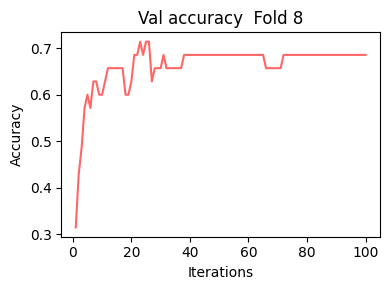

Processing Fold 9 ...


Epoch 25:   train/loss: 0.9568   valid/loss: 1.0883   train/acc: 0.9185   train/f1: 0.9176   valid/acc: 0.7429   valid/f1: 0.7244
Epoch 50:   train/loss: 0.9296   valid/loss: 1.0384   train/acc: 0.9342   train/f1: 0.9336   valid/acc: 0.7143   valid/f1: 0.6996
Epoch 75:   train/loss: 0.8925   valid/loss: 1.0249   train/acc: 0.9436   train/f1: 0.9425   valid/acc: 0.7429   valid/f1: 0.7265
Epoch 100:  train/loss: 0.8848   valid/loss: 1.0279   train/acc: 0.9404   train/f1: 0.9398   valid/acc: 0.7429   valid/f1: 0.7263

Training completed!


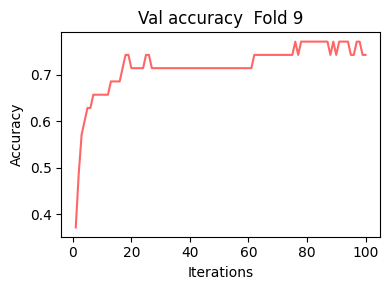

Processing Fold 10 ...


Epoch 25:   train/loss: 0.9740   valid/loss: 1.1064   train/acc: 0.9185   train/f1: 0.9188   valid/acc: 0.6571   valid/f1: 0.6530
Epoch 50:   train/loss: 0.8979   valid/loss: 1.0920   train/acc: 0.9310   train/f1: 0.9314   valid/acc: 0.6571   valid/f1: 0.6552
Epoch 75:   train/loss: 0.8696   valid/loss: 1.0977   train/acc: 0.9404   train/f1: 0.9403   valid/acc: 0.6571   valid/f1: 0.6471
Epoch 100:  train/loss: 0.8961   valid/loss: 1.0876   train/acc: 0.9404   train/f1: 0.9405   valid/acc: 0.6857   valid/f1: 0.6723

Training completed!


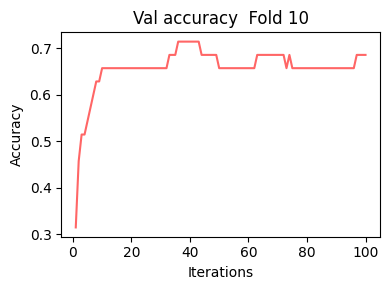

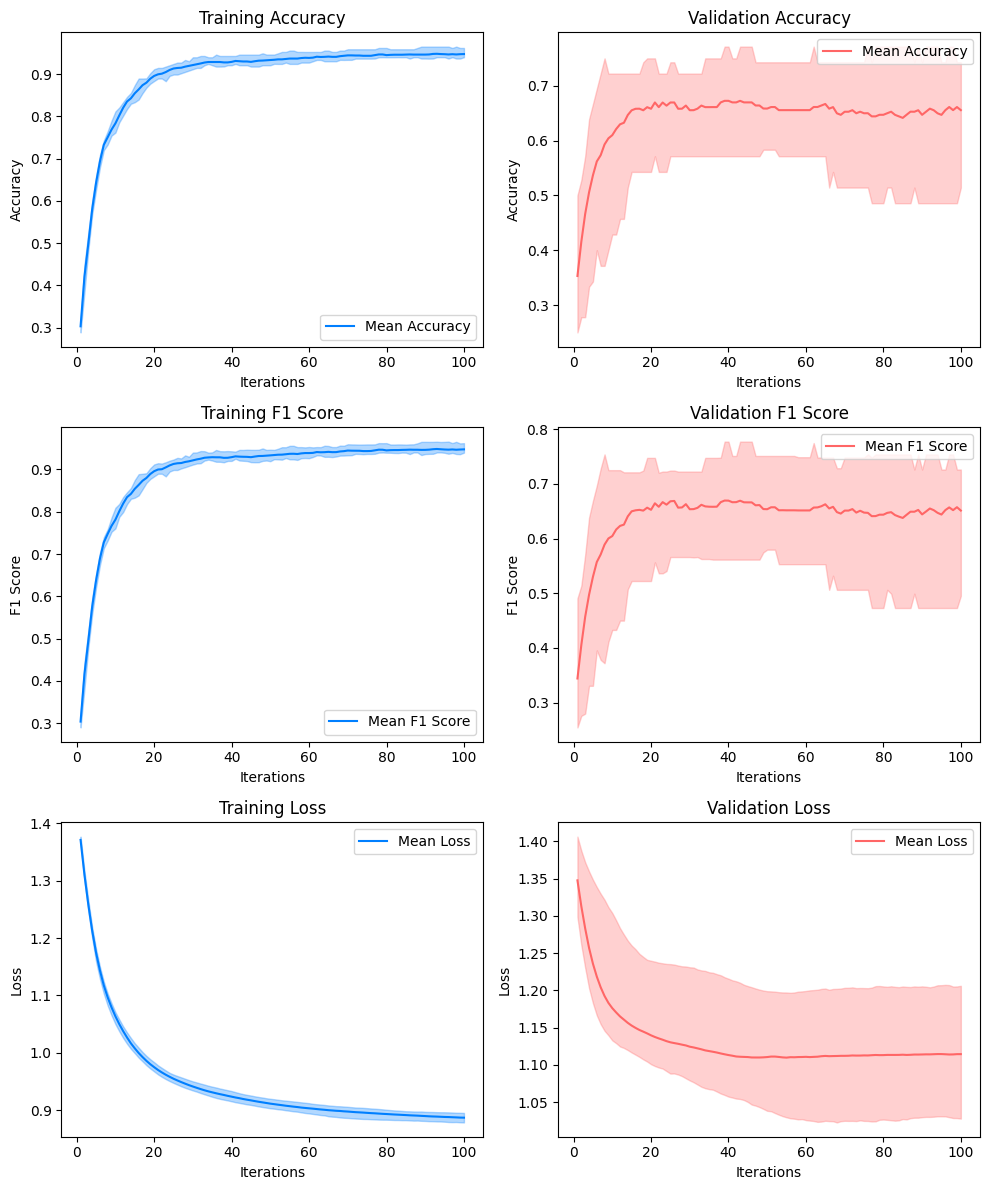

In [ ]:
EPOCHS = 100
SPLIT = 10
EARLY_STOPPING = None

custom_primary = '#007FFF'
custom_secondary = '#FF6666'

# Grid search
for lr in [1e-2]:
    for bs in [64]:

        cv = StratifiedKFold(n_splits=SPLIT, random_state=SEED, shuffle=True)
        circuits_np = np.array(circuits, dtype=object)
        targets_np = np.array(targets, dtype=object)

        train_accuracies = []
        val_accuracies = []
        train_losses = []
        val_losses = []
        train_f1 = []
        val_f1 = []

        for i, (train_index, val_index) in enumerate(cv.split(circuits_np, targets_np.argmax(1))):

            print(f'Processing Fold {i+1} ...')

            train_fold = Dataset(circuits_np[train_index], targets_np[train_index], batch_size=bs)
            val_fold = Dataset(circuits_np[val_index], targets_np[val_index])

            model = QuantumModel.from_diagrams(circuits)
            model.initialise_weights()

            trainer = PytorchTrainer(
                model=model,
                loss_function=torch.nn.CrossEntropyLoss(),
                optimizer=torch.optim.AdamW,
                learning_rate=lr,
                epochs=EPOCHS,
                evaluate_functions=eval_metrics,
                evaluate_on_train=True,
                verbose='text',
                seed=SEED
            )

            trainer.fit(train_fold, val_fold, log_interval=25, early_stopping_interval=EARLY_STOPPING)

            train_accuracies.append(trainer.train_eval_results['acc'])
            val_accuracies.append(trainer.val_eval_results['acc'])

            train_f1.append(trainer.train_eval_results['f1'])
            val_f1.append(trainer.val_eval_results['f1'])

            train_losses.append(trainer.train_epoch_costs)
            val_losses.append(trainer.val_costs)

            fig, axes = plt.subplots(1, 1, figsize=(4, 3))

            # Plot for training accuracy
            axes.set_title(f'Val accuracy  Fold {i+1}')
            axes.set_xlabel('Iterations')
            axes.set_ylabel('Accuracy')
            axes.plot(np.arange(1, len(trainer.train_epoch_costs) + 1), trainer.val_eval_results['acc'], color=custom_secondary)

            plt.tight_layout()
            plt.show()

        range_ = np.arange(1, len(trainer.train_epoch_costs) + 1)

        # Calculate mean, min, and max metrics
        mean_train_accuracy = np.mean(train_accuracies, axis=0)
        min_train_accuracy = np.min(train_accuracies, axis=0)
        max_train_accuracy = np.max(train_accuracies, axis=0)

        mean_val_accuracy = np.mean(val_accuracies, axis=0)
        min_val_accuracy = np.min(val_accuracies, axis=0)
        max_val_accuracy = np.max(val_accuracies, axis=0)

        mean_train_f1 = np.mean(train_f1, axis=0)
        min_train_f1 = np.min(train_f1, axis=0)
        max_train_f1 = np.max(train_f1, axis=0)

        mean_val_f1 = np.mean(val_f1, axis=0)
        min_val_f1 = np.min(val_f1, axis=0)
        max_val_f1 = np.max(val_f1, axis=0)

        mean_train_loss = np.mean(train_losses, axis=0)
        min_train_loss = np.min(train_losses, axis=0)
        max_train_loss = np.max(train_losses, axis=0)

        mean_val_loss = np.mean(val_losses, axis=0)
        min_val_loss = np.min(val_losses, axis=0)
        max_val_loss = np.max(val_losses, axis=0)

        fig, axes = plt.subplots(3, 2, figsize=(10, 12))

        # Plot for training accuracy
        axes[0, 0].set_title('Training Accuracy')
        axes[0, 0].set_xlabel('Iterations')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].plot(range_, mean_train_accuracy, color=custom_primary, label='Mean Accuracy')
        axes[0, 0].fill_between(range_, min_train_accuracy, max_train_accuracy, color=custom_primary, alpha=0.3)
        axes[0, 0].legend()

        # Plot for validation accuracy
        axes[0, 1].set_title('Validation Accuracy')
        axes[0, 1].set_xlabel('Iterations')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].plot(range_, mean_val_accuracy, color=custom_secondary, label='Mean Accuracy')
        axes[0, 1].fill_between(range_, min_val_accuracy, max_val_accuracy, color=custom_secondary, alpha=0.3)
        axes[0, 1].legend()

        # Plot for training F1 score
        axes[1, 0].set_title('Training F1 Score')
        axes[1, 0].set_xlabel('Iterations')
        axes[1, 0].set_ylabel('F1 Score')
        axes[1, 0].plot(range_, mean_train_f1, color=custom_primary, label='Mean F1 Score')
        axes[1, 0].fill_between(range_, min_train_f1, max_train_f1, color=custom_primary, alpha=0.3)
        axes[1, 0].legend()

        # Plot for validation F1 score
        axes[1, 1].set_title('Validation F1 Score')
        axes[1, 1].set_xlabel('Iterations')
        axes[1, 1].set_ylabel('F1 Score')
        axes[1, 1].plot(range_, mean_val_f1, color=custom_secondary, label='Mean F1 Score')
        axes[1, 1].fill_between(range_, min_val_f1, max_val_f1, color=custom_secondary, alpha=0.3)
        axes[1, 1].legend()

        # Plot for training loss
        axes[2, 0].set_title('Training Loss')
        axes[2, 0].set_xlabel('Iterations')
        axes[2, 0].set_ylabel('Loss')
        axes[2, 0].plot(range_, mean_train_loss, color=custom_primary, label='Mean Loss')
        axes[2, 0].fill_between(range_, min_train_loss, max_train_loss, color=custom_primary, alpha=0.3)
        axes[2, 0].legend()

        # Plot for validation loss
        axes[2, 1].set_title('Validation Loss')
        axes[2, 1].set_xlabel('Iterations')
        axes[2, 1].set_ylabel('Loss')
        axes[2, 1].plot(range_, mean_val_loss, color=custom_secondary, label='Mean Loss')
        axes[2, 1].fill_between(range_, min_val_loss, max_val_loss, color=custom_secondary, alpha=0.3)
        axes[2, 1].legend()

        plt.tight_layout()
        plt.show()